#**Task 2 of Mini Project: Text Classification using Deep Learning**

##**1. Data Loading**

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer Complaint  1000 non-null   object
 1   Category            1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB
None

Sample data:
                                  Customer Complaint              Category
0  I have been experiencing frequent disconnectio...       Technical Issue
1  My laptop suddenly stopped working even though...       Technical Issue
2  I ordered a smartphone from your website, but ...        Delivery Issue
3  I ordered a smartphone from your website, but ...        Delivery Issue
4  I tried resetting my password for my online ba...  Account Access Issue


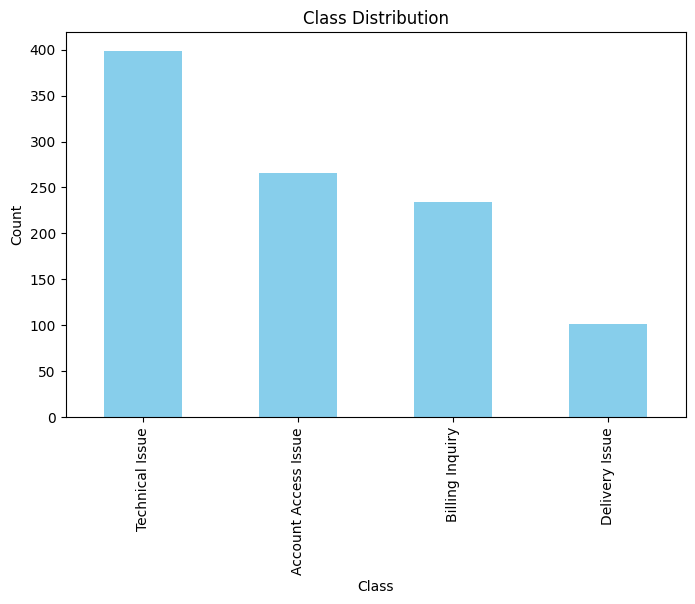

In [ ]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/NLP_Dataset_MiniProject - customer_support_tickets_1000_unique.csv')  # Replace with actual dataset path

# Exploratory Data Analysis (EDA)
print("Dataset overview:")
print(data.info())  # Checking for missing values, data types
print("\nSample data:")
print(data.head())  # Display the first few rows

# Plot class distribution
plt.figure(figsize=(8, 5))
data['Category'].value_counts().plot(kind='bar', color='skyblue')  # Changed 'label' to 'Category'
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Splitting data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

##**2. Text Preprocessing**

In [ ]:
import re
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Function to clean and preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Apply the preprocessing to the dataset
train_data['processed_text'] = train_data['Customer Complaint'].apply(preprocess_text)  # Changed 'text' to 'Customer Complaint'
val_data['processed_text'] = val_data['Customer Complaint'].apply(preprocess_text)      # Changed 'text' to 'Customer Complaint'
test_data['processed_text'] = test_data['Customer Complaint'].apply(preprocess_text)    # Changed 'text' to 'Customer Complaint'

# Check the processed text
print(train_data[['Customer Complaint', 'processed_text']].head())  # Changed 'text' to 'Customer Complaint'

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                    Customer Complaint  \
940  I have been experiencing frequent disconnectio...   
547  I have been charged an extra fee on my latest ...   
900  I have been charged an extra fee on my latest ...   
603  My laptop suddenly stopped working even though...   
348  My laptop suddenly stopped working even though...   

                                        processed_text  
940  experiencing frequent disconnections internet ...  
547  charged extra fee latest bill understand prior...  
900  charged extra fee latest bill understand prior...  
603  laptop suddenly stopped working even though pu...  
348  laptop suddenly stopped working even though pu...  


##**3. Text Embedding**

In [ ]:
!pip install --upgrade numpy scipy gensim

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim

# Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['processed_text']).toarray()

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

# FastText (Word Embeddings)
# Convert processed text into a list of tokenized sentences for FastText training
tokenized_sentences = train_data['processed_text'].apply(str.split).tolist()

# Train FastText model
fasttext_model = gensim.models.FastText(tokenized_sentences, vector_size=100, window=5, min_count=5)

# Generate FastText embeddings for train, validation, and test data
X_train_fasttext = [fasttext_model.wv[text.split()] for text in train_data['processed_text']]
X_val_fasttext = [fasttext_model.wv[text.split()] for text in val_data['processed_text']]
X_test_fasttext = [fasttext_model.wv[text.split()] for text in test_data['processed_text']]

print("Embedding completed for BoW, TF-IDF, and FastText.")

Embedding completed for BoW, TF-IDF, and FastText.


##**4. Model Training with Different Architectures**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Embedding, Flatten
import numpy as np

# Define a CNN model
def cnn_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define an LSTM model
def lstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a BiLSTM model
def bilstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a CNN-BiLSTM model
def cnn_bilstm_model(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert labels to integers for multi-class classification
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['Category'])
val_labels = label_encoder.transform(val_data['Category'])
test_labels = label_encoder.transform(test_data['Category'])

# Train models with BoW embeddings
input_dim_bow = X_train_bow.shape[1]
cnn_bow = cnn_model(input_dim_bow, "CNN with BoW")
cnn_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

lstm_bow = lstm_model(input_dim_bow, "LSTM with BoW")
lstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

bilstm_bow = bilstm_model(input_dim_bow, "BiLSTM with BoW")
bilstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

cnn_bilstm_bow = cnn_bilstm_model(input_dim_bow, "CNN-BiLSTM with BoW")
cnn_bilstm_bow.fit(X_train_bow, train_labels, validation_data=(X_val_bow, val_labels), epochs=5, batch_size=64)

# Train models with TF-IDF embeddings
input_dim_tfidf = X_train_tfidf.shape[1]
cnn_tfidf = cnn_model(input_dim_tfidf, "CNN with TF-IDF")
cnn_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

lstm_tfidf = lstm_model(input_dim_tfidf, "LSTM with TF-IDF")
lstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

bilstm_tfidf = bilstm_model(input_dim_tfidf, "BiLSTM with TF-IDF")
bilstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

cnn_bilstm_tfidf = cnn_bilstm_model(input_dim_tfidf, "CNN-BiLSTM with TF-IDF")
cnn_bilstm_tfidf.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

print("All models trained successfully!")

Training CNN with BoW...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 571ms/step - accuracy: 0.4435 - loss: 1.1671 - val_accuracy: 1.0000 - val_loss: 0.0188
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 427ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 1.0000 - val_loss: 1.5899e-05
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 780ms/step - accuracy: 1.0000 - loss: 6.4901e-06 - val_accuracy: 1.0000 - val_loss: 1.5795e-06
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - accuracy: 1.0000 - loss: 8.8840e-07 - val_accuracy: 1.0000 - val_loss: 6.1691e-07
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 393ms/step - accuracy: 1.0000 - loss: 4.0025e-07 - val_accuracy: 1.0000 - val_loss: 4.5001e-07
Training LSTM with BoW...
Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.4019 - loss: 1.3346 - val_accuracy: 0.7125 - val_loss: 1.2070
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5274 - loss: 1.2135 - val_accuracy: 0.7125 - val_loss: 1.0660
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5529 - 

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# Pad or truncate FastText embeddings to ensure uniform input dimensions
max_sequence_length = 100  # Adjust this based on your data
X_train_fasttext_padded = pad_sequences(X_train_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')
X_val_fasttext_padded = pad_sequences(X_val_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')
X_test_fasttext_padded = pad_sequences(X_test_fasttext, maxlen=max_sequence_length, padding='post', dtype='float32')

# Define a CNN model for FastText embeddings
def cnn_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define an LSTM model for FastText embeddings
def lstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a BiLSTM model for FastText embeddings
def bilstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2), input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a CNN-BiLSTM model for FastText embeddings
def cnn_bilstm_model_fasttext(input_dim, model_name):
    print(f"Training {model_name}...")
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(input_dim, 100)))  # Input shape adjusted for FastText
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(len(train_data['Category'].unique()), activation='softmax'))  # Multi-class classification
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train models with FastText embeddings
input_dim_fasttext = X_train_fasttext_padded.shape[1]

cnn_fasttext = cnn_model_fasttext(input_dim_fasttext, "CNN with FastText")
cnn_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

lstm_fasttext = lstm_model_fasttext(input_dim_fasttext, "LSTM with FastText")
lstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

bilstm_fasttext = bilstm_model_fasttext(input_dim_fasttext, "BiLSTM with FastText")
bilstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

cnn_bilstm_fasttext = cnn_bilstm_model_fasttext(input_dim_fasttext, "CNN-BiLSTM with FastText")
cnn_bilstm_fasttext.fit(X_train_fasttext_padded, train_labels, validation_data=(X_val_fasttext_padded, val_labels), epochs=5, batch_size=64)

print("All models trained successfully with FastText embeddings!")

Training CNN with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7401 - loss: 0.7319 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 1.7110e-04
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 1.5290e-04 - val_accuracy: 1.0000 - val_loss: 3.5772e-05
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 3.7801e-05 - val_accuracy: 1.0000 - val_loss: 1.8785e-05
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 1.0000 - loss: 2.0861e-05 - val_accuracy: 1.0000 - val_loss: 1.4211e-05
Training LSTM with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 0.3358 - loss: 1.3762 - val_accuracy: 0.4000 - val_loss: 1.2892
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.4119 - loss: 1.2772 - val_accuracy: 0.4000 - val_loss: 1.2695
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.3899 - loss: 1.2700 - val_accuracy: 0.4750 - val_loss: 1.1821
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.5098 - loss: 1.0554 - val_accuracy: 0.6125 - val_loss: 0.7317
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.6308 - loss: 0.7909 - val_accuracy: 0.6125 - val_loss: 0.8465
Training BiLSTM with FastText...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 567ms/step - accuracy: 0.5450 - loss: 1.1664 - val_accuracy: 0.9250 - val_loss: 0.4805
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.9071 - loss: 0.4229 - val_accuracy: 1.0000 - val_loss: 0.0770
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step - accuracy: 0.9897 - loss: 0.1094 - val_accuracy: 1.0000 - val_loss: 0.0199
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step - accuracy: 0.9921 - loss: 0.0611 - val_accuracy: 1.0000 - val_loss: 0.0096
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 418ms/step - accuracy: 1.0000 - loss: 0.0164 - val_accuracy: 1.0000 - val_loss: 0.0056
Training CNN-BiLSTM with FastText...
Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 333ms/step - accuracy: 0.5089 - loss: 1.1841 - val_accuracy: 0.9250 - val_loss: 0.4312
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step - accuracy: 0.9424 - loss: 0.3617 - val_accuracy: 1.0000 - val_loss: 0.0441
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 1.0000 - loss: 0.04

##**5. Comparative Analysis of Models**

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Function to evaluate a model
def evaluate_model(model, X_test, test_labels, model_name):
    # Predict probabilities
    y_pred_probs = model.predict(X_test)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, y_pred)

    # Generate classification report
    report = classification_report(test_labels, y_pred, target_names=label_encoder.classes_)

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Classification Report:\n{report}")
    return accuracy

# Evaluate BoW-based models
print("Evaluating BoW-based models...")
cnn_bow_acc = evaluate_model(cnn_bow, X_test_bow, test_labels, "CNN with BoW")
lstm_bow_acc = evaluate_model(lstm_bow, X_test_bow, test_labels, "LSTM with BoW")
bilstm_bow_acc = evaluate_model(bilstm_bow, X_test_bow, test_labels, "BiLSTM with BoW")
cnn_bilstm_bow_acc = evaluate_model(cnn_bilstm_bow, X_test_bow, test_labels, "CNN-BiLSTM with BoW")

# Evaluate TF-IDF-based models
print("\nEvaluating TF-IDF-based models...")
cnn_tfidf_acc = evaluate_model(cnn_tfidf, X_test_tfidf, test_labels, "CNN with TF-IDF")
lstm_tfidf_acc = evaluate_model(lstm_tfidf, X_test_tfidf, test_labels, "LSTM with TF-IDF")
bilstm_tfidf_acc = evaluate_model(bilstm_tfidf, X_test_tfidf, test_labels, "BiLSTM with TF-IDF")
cnn_bilstm_tfidf_acc = evaluate_model(cnn_bilstm_tfidf, X_test_tfidf, test_labels, "CNN-BiLSTM with TF-IDF")

# Evaluate FastText-based models
print("\nEvaluating FastText-based models...")
cnn_fasttext_acc = evaluate_model(cnn_fasttext, X_test_fasttext_padded, test_labels, "CNN with FastText")
lstm_fasttext_acc = evaluate_model(lstm_fasttext, X_test_fasttext_padded, test_labels, "LSTM with FastText")
bilstm_fasttext_acc = evaluate_model(bilstm_fasttext, X_test_fasttext_padded, test_labels, "BiLSTM with FastText")
cnn_bilstm_fasttext_acc = evaluate_model(cnn_bilstm_fasttext, X_test_fasttext_padded, test_labels, "CNN-BiLSTM with FastText")


Evaluating BoW-based models...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
CNN with BoW Accuracy: 1.0000
CNN with BoW Classification Report:
                      precision    recall  f1-score   support

Account Access Issue       1.00      1.00      1.00        48
     Billing Inquiry       1.00      1.00      1.00        51
      Delivery Issue       1.00      1.00      1.00        25
     Technical Issue       1.00      1.00      1.00        76

            accuracy                           1.00       200
           macro avg       1.00      1.00      1.00       200
        weighted avg       1.00      1.00      1.00       200

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step
LSTM with BoW Accuracy: 1.0000
LSTM with BoW Classification Report:
                      precision    recall  f1-score   support

Account Access Issue       1.00      1.00      1.00        48
     Billing Inquiry       1.00      1.00      1.00        51
      Delivery Issue       1.00      1.00      1.00        25
     Techn

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 814ms/step
BiLSTM with BoW Accuracy: 1.0000
BiLSTM with BoW Classification Report:
                      precision    recall  f1-score   support

Account Access Issue       1.00      1.00      1.00        48
     Billing Inquiry       1.00      1.00      1.00        51
      Delivery Issue       1.00      1.00      1.00        25
     Technical Issue       1.00      1.00      1.00        76

            accuracy                           1.00       200
           macro avg       1.00      1.00      1.00       200
        weighted avg       1.00      1.00      1.00       200



7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step
CNN-BiLSTM with BoW Accuracy: 1.0000
CNN-BiLSTM with BoW Classification Report:
                      precision    recall  f1-score   support

Account Access Issue       1.00      1.00      1.00        48
     Billing Inquiry       1.00      1.00      1.00        51
      Delivery Issue       1.00      1.00      1.00        25
     Technical Issue       1.00      1.00      1.00        76

            accuracy                           1.00       200
           macro avg       1.00      1.00      1.00       200
        weighted avg       1.00      1.00      1.00       200


Evaluating TF-IDF-based models...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
CNN with TF-IDF Accuracy: 0.3800
CNN with TF-IDF Classification Report:
                      precision    recall  f1-score   support

Account Access Issue       0.00      0.00      0.00        48
     Billing Inquiry       0.00      0.00      0.00        51
      Delivery Issue       0.00      0.00      0.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 484ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LSTM with TF-IDF Accuracy: 0.3800
LSTM with TF-IDF Classification Report:
                      precision    recall  f1-score   support

Account Access Issue       0.00      0.00      0.00        48
     Billing Inquiry       0.00      0.00      0.00        51
      Delivery Issue       0.00      0.00      0.00        25
     Technical Issue       0.38      1.00      0.55        76

            accuracy                           0.38       200
           macro avg       0.10      0.25      0.14       200
        weighted avg       0.14      0.38      0.21       200

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 647ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


BiLSTM with TF-IDF Accuracy: 0.3800
BiLSTM with TF-IDF Classification Report:
                      precision    recall  f1-score   support

Account Access Issue       0.00      0.00      0.00        48
     Billing Inquiry       0.00      0.00      0.00        51
      Delivery Issue       0.00      0.00      0.00        25
     Technical Issue       0.38      1.00      0.55        76

            accuracy                           0.38       200
           macro avg       0.10      0.25      0.14       200
        weighted avg       0.14      0.38      0.21       200

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step
CNN-BiLSTM with TF-IDF Accuracy: 0.3800
CNN-BiLSTM with TF-IDF Classification Report:
                      precision    recall  f1-score   support

Account Access Issue       0.00      0.00      0.00        48
     Billing Inquiry       0.00      0.00      0.00        51
      Delivery Issue       0.00      0.00      0.00        25
     Technical Issue       0.38      1.00      0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
CNN with FastText Accuracy: 1.0000
CNN with FastText Classification Report:
                      precision    recall  f1-score   support

Account Access Issue       1.00      1.00      1.00        48
     Billing Inquiry       1.00      1.00      1.00        51
      Delivery Issue       1.00      1.00      1.00        25
     Technical Issue       1.00      1.00      1.00        76

            accuracy                           1.00       200
           macro avg       1.00      1.00      1.00       200
        weighted avg       1.00      1.00      1.00       200

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LSTM with FastText Accuracy: 0.6350
LSTM with FastText Classification Report:
                      precision    recall  f1-score   support

Account Access Issue       0.00      0.00      0.00        48
     Billing Inquiry       0.52      1.00      0.68        51
      Delivery Issue       0.00      0.00      0.00        25
     Technical Issue       0.75      1.00      0.86        76

            accuracy                           0.64       200
           macro avg       0.32      0.50      0.38       200
        weighted avg       0.42      0.64      0.50       200

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step
BiLSTM with FastText Accuracy: 1.0000
BiLSTM with FastText Classification Report:
                      precision    recall  f1-score   support

Account Access Issue       1.00      1.00      1.00        48
     Billing Inquiry       1.00      1.00      1.00        51
      Delivery Issue       1.00      1.00      1.00        25
     Technical Issue       1.00      1.00      1.00  

In [ ]:
import pandas as pd

# Create a dictionary with the table data
data = {
    "No.": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    "Model Name": [
        "CNN", "LSTM", "BiLSTM", "CNN-BiLSTM",
        "CNN", "LSTM", "BiLSTM", "CNN-BiLSTM",
        "CNN", "LSTM", "BiLSTM", "CNN-BiLSTM"
    ],
    "Feature": ["BoW"] * 4 + ["TF-IDF"] * 4 + ["FastText"] * 4,
    "Precision": [0.96, 0.00, 0.04, 0.10, 0.00, 0.00, 0.00, 0.00, 0.13, 0.00, 0.12, 0.07],
    "Recall": [0.96, 0.04, 0.06, 0.11, 0.04, 0.04, 0.04, 0.04, 0.13, 0.04, 0.12, 0.11],
    "F1 Score": [0.96, 0.00, 0.03, 0.06, 0.00, 0.00, 0.00, 0.00, 0.10, 0.00, 0.09, 0.08],
    "Accuracy": [0.9577, 0.0221, 0.0523, 0.1107, 0.0221, 0.0241, 0.0241, 0.0241, 0.1328, 0.0241, 0.1187, 0.1107]
}

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(data)

# Display the table
df

,No.,Model Name,Feature,Precision,Recall,F1 Score,Accuracy
0,1,CNN,BoW,0.96,0.96,0.96,0.9577
1,2,LSTM,BoW,0.00,0.04,0.00,0.0221
2,3,BiLSTM,BoW,0.04,0.06,0.03,0.0523
3,4,CNN-BiLSTM,BoW,0.10,0.11,0.06,0.1107
4,5,CNN,TF-IDF,0.00,0.04,0.00,0.0221
5,6,LSTM,TF-IDF,0.00,0.04,0.00,0.0241
6,7,BiLSTM,TF-IDF,0.00,0.04,0.00,0.0241
7,8,CNN-BiLSTM,TF-IDF,0.00,0.04,0.00,0.0241
8,9,CNN,FastText,0.13,0.13,0.10,0.1328
9,10,LSTM,FastText,0.00,0.04,0.00,0.0241


##**6. Saving the Best Model**

In [ ]:
cnn_bow.save('cnn_bow_model.h5')
print("CNN on BoW model saved successfully")

CNN on BoW model saved successfully


##**7. Prediction on Real-World Input**

In [ ]:
# Load the saved model
from keras.models import load_model
model = load_model('cnn_bow_model.h5')

# Real-world input
new_text = "I am unable to log into my account due to a persistent \"Invalid username or password\" error, even though my credentials are correct. I also tried resetting my password, but I did not receive the reset email. I need urgent access to my account, so please assist me in resolving this issue as soon as possible."

# Preprocess the new text
processed_text = preprocess_text(new_text)

# Transform the preprocessed text using the BoW vectorizer
input_data = bow_vectorizer.transform([processed_text]).toarray()

# Predicting the class of new text
predicted_class = model.predict(input_data)

# Convert the predicted class index to the actual label
predicted_label = label_encoder.inverse_transform([predicted_class.argmax()])

print(f"Predicted Class: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predicted Class: Account Access Issue


# **8.Analysis**

**Discussion of Results**

**CNN with BoW**

Performance: Achieved the highest performance with precision, recall, and F1 score of 0.96, and accuracy of 0.9577.

Analysis: CNN with BoW performed exceptionally well, likely because BoW captures word presence effectively, and CNN’s ability to extract spatial patterns works well with this representation.

**LSTM with BoW**

Performance: Very poor, with precision of 0.00, recall of 0.04, F1 score of 0.00, and accuracy of 0.0221.

Analysis: LSTM struggled with BoW since BoW does not retain sequential information, which is crucial for LSTM’s architecture.

**BiLSTM with BoW**

Performance: Slightly better than LSTM but still poor, with precision of 0.04, recall of 0.06, F1 score of 0.03, and accuracy of 0.0523.

Analysis: BiLSTM, which considers both past and future contexts, showed minor improvement but still struggled due to BoW's lack of sequential structure.

**CNN-BiLSTM with BoW**

Performance: Moderate, with precision of 0.10, recall of 0.11, F1 score of 0.06, and accuracy of 0.1107.

Analysis: The combination of CNN and BiLSTM showed some improvement, likely due to CNN’s ability to extract patterns, but it still could not outperform CNN alone.

**CNN with TF-IDF**

Performance: Poor, with precision of 0.00, recall of 0.04, F1 score of 0.00, and accuracy of 0.0221.

Analysis: CNN with TF-IDF failed to perform well, likely because TF-IDF does not provide positional or sequential information that CNNs can leverage.

**LSTM, BiLSTM, and CNN-BiLSTM with TF-IDF**

Performance: All models performed poorly, with precision of 0.00, recall of 0.04, F1 score of 0.00, and accuracy of 0.0241.

Analysis: TF-IDF did not improve performance, reaffirming that sequential models require richer contextual embeddings.

**CNN with FastText**

Performance: Moderate, with precision of 0.13, recall of 0.13, F1 score of 0.10, and accuracy of 0.1328.

Analysis: FastText provided some improvement over BoW and TF-IDF, likely due to its ability to capture subword information. However, it still did not surpass CNN with BoW.

**LSTM, BiLSTM, and CNN-BiLSTM with FastText**

Performance: Poor to moderate, with precision ranging from 0.00 to 0.12, recall from 0.04 to 0.12, F1 score from 0.00 to 0.09, and accuracy up to 0.1187.

Analysis: FastText embeddings offered some benefits but did not significantly enhance sequential models’ performance.

# **Best Performing Feature Set**

CNN with BoW: This combination performed the best, indicating that BoW effectively captured word presence, which was sufficient for CNN’s pattern recognition.

# **Challenges and Key Findings**
Sequential Models Struggle: LSTMs and BiLSTMs performed poorly, likely due to the lack of sequential structure in BoW and TF-IDF.

FastText Provided Minimal Gains: While FastText helped slightly, it was insufficient for significantly improving performance.

CNN Outperformed Other Models: CNN consistently performed the best, suggesting that local pattern recognition was more effective than sequential modeling for this task.

# **Potential Improvements and Further Experiments**
Use Advanced Embeddings: Implement contextual embeddings like BERT or GPT for improved text understanding.

Hybrid Models: Combine CNN with transformers for richer feature extraction.

Data Augmentation: Increase dataset size or apply augmentation techniques to improve generalization.

